### 1. Library Import 

In [4]:
import pandas as pd
import re
import unicodedata 
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as STOP_FR
from spacy.lang.en.stop_words import STOP_WORDS as STOP_EN
from langdetect import detect

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models import LdaMulticore
import matplotlib.pyplot as plt

import requests
import time

import threading

import os
import pickle
import numpy as np

from collections import defaultdict, Counter
import ast

from collections import Counter

### 2. Data Import

In [50]:
df=pd.read_csv('CAIRN_chunks_and_authors.csv')

In [51]:
display(df)

,url,Unnamed: 0,titre,auteur,section,twitter_card,journal,annee,numero,page_debut,...,variante_recherchee,name,nom_auteur_absent,author_name_absent,chunk,presence_auteur,any_author_in_chunk,author_present_in_article_x,author_present_in_article_y,author_present_in_article
0,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,Ackerman,Galia Ackerman,False,False,L 'objectif de ce chapitre est d'envisager à q...,0,False,True,True,True
1,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,Ackerman,Galia Ackerman,False,False,"Elle dépend, d'autre part, de l'identité de j ...",0,False,True,True,True
2,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,Ackerman,Galia Ackerman,False,False,"La politique inverse est alors envisageable, à...",1,True,True,True,True
3,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,Ackerman,Galia Ackerman,False,False,Ils sont supposés maximiser leur utilité de ma...,0,False,True,True,True
4,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,Ackerman,Galia Ackerman,False,False,4) Un décalage entre les actions présentes et ...,0,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89916,https://stm.cairn.info/violences-de-la-maladie...,26782 | 20315 | 22977,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,...,Dostoïevski | F. Dostoievski | F. Dostoïevski,Fiodor Dostoïevski,False,False,Disparaît pour mon existence la possibilité d...,0|0|0,False,True,True,True
89917,https://stm.cairn.info/violences-de-la-maladie...,26782 | 20315 | 22977,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,...,Dostoïevski | F. Dostoievski | F. Dostoïevski,Fiodor Dostoïevski,False,False,"Décrite dans la littérature médicale, elle pas...",1|1|1,True,True,True,True
89918,https://stm.cairn.info/violences-de-la-maladie...,26782 | 20315 | 22977,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,...,Dostoïevski | F. Dostoievski | F. Dostoïevski,Fiodor Dostoïevski,False,False,Sans quoi cette nouvelle perception ne fait qu...,0|0|0,False,True,True,True
89919,https://stm.cairn.info/violences-de-la-maladie...,26782 | 20315 | 22977,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,...,Dostoïevski | F. Dostoievski | F. Dostoïevski,Fiodor Dostoïevski,False,False,Le sujet est ramené à lui-même par le biais d’...,1|1|1,True,True,True,True


### 3. Data manipulation

#### 3.b Data simple cleaning 

In [52]:
def clean_text_for_lda(text: str) -> str:
    import re, unicodedata

    text = text.lower()
    text = unicodedata.normalize("NFC", text)
    text = text.replace("’", "'")
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"\S+@\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[!?:;,.\(\)\[\]\{\}«»\"…]", " ", text)
    text = re.sub(r"(?<!\w)-(?!\w)", " ", text)
    text = re.sub(r"\b\d+\b", " ", text)
    text = re.sub(r"[^a-zàâäçéèêëîïôöùûüÿœæ_ ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [53]:
df["chunk_clean"] = df["chunk"].apply(clean_text_for_lda)

#### 3.a Language detection

In [54]:
def detect_lang_extended(text):
    try:
        lang = detect(text)
    except:
        return "other"     

    if lang in ("fr", "en"):
        return lang
    else:
        return "other"  

In [55]:
df["langue"] = df["chunk_clean"].apply(detect_lang_extended)

In [56]:
def count_languages(lang_series):
    counts = lang_series.value_counts(dropna=False).to_dict()
    return {
        "fr": counts.get("fr", 0),
        "en": counts.get("en", 0),
        "other": counts.get("other", 0)
    }
resultats = count_languages(df["langue"])
print(resultats)

{'fr': 88097, 'en': 1408, 'other': 416}


In [57]:
df_filtered = df[df["langue"].isin(["fr", "en"])]

In [58]:
df_filtered.to_csv("2CAIRN_chunks_en_and_fr_bootstrap.csv", index=False, encoding="utf-8")

#### 3.c Tokenization, lemmatization and removing stopwords 

In [15]:
nlp_fr = spacy.load("fr_core_news_md")
nlp_en = spacy.load("en_core_web_md")


def tokenize_lemmatize_multilang_batch(texts, langs, batch_size=50):
    """
    Batch tokenization & lemmatization for a list of texts.
    Uses spaCy's nlp.pipe for high performance.
    'texts' : list of strings
    'langs' : list of 'fr' or 'en'
    """
    
    # Separate texts by language  
    fr_indices = [i for i, l in enumerate(langs) if l == "fr"]
    en_indices = [i for i, l in enumerate(langs) if l == "en"]

    fr_texts = [texts[i] for i in fr_indices]
    en_texts = [texts[i] for i in en_indices]

    # storage
    results = [None] * len(texts)

    # --- French batch processing ---
    for doc, idx in zip(nlp_fr.pipe(fr_texts, batch_size=batch_size), fr_indices):
        tokens = [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha
            and token.lemma_.lower() not in STOP_FR
            and len(token.lemma_) > 2
        ]
        results[idx] = tokens

    # --- English batch processing ---
    for doc, idx in zip(nlp_en.pipe(en_texts, batch_size=batch_size), en_indices):
        tokens = [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha
            and token.lemma_.lower() not in STOP_EN
            and len(token.lemma_) > 2
        ]
        results[idx] = tokens

    return results


In [16]:
texts = df_filtered["chunk_clean"].tolist()
langs = df_filtered["langue"].tolist()

df_filtered["tokens"] = tokenize_lemmatize_multilang_batch(
    texts, langs, batch_size=50
)

df_filtered.to_csv("CAIRN_bootsrap_token")

### 4. LDA

#### 4.a Topic number selection - using bootstrap

In [17]:
# ============================================================================
# BLOCK 1: UTILITY FUNCTIONS
# ============================================================================

def save_state(state, filename='lda_state.pkl'):
    """Save current processing state"""
    try:
        with open(filename, 'wb') as f:
            pickle.dump(state, f)
        print(f"✓ State saved: {filename}")
        return True
    except Exception as e:
        print(f"✗ Error saving state: {e}")
        return False

def load_state(filename='lda_state.pkl'):
    """Load saved state if exists"""
    try:
        if os.path.exists(filename):
            with open(filename, 'rb') as f:
                state = pickle.load(f)
            print(f"✓ State loaded: {filename}")
            return state
        return None
    except Exception as e:
        print(f"✗ Error loading state: {e}")
        return None

print("="*80)
print("BLOCK 1 COMPLETED: Utility functions loaded")
print("="*80)

BLOCK 1 COMPLETED: Utility functions loaded


In [18]:
# ============================================================================
# BLOCK 2: DATA PREPARATION
# ============================================================================
print("="*80)
print("BLOCK 2: DATA PREPARATION")
print("="*80)

# Check for existing state
existing_state = load_state()

if existing_state and 'corpus' in existing_state:
    print("Loading existing data...")
    dictionary = existing_state['dictionary']
    corpus = existing_state['corpus']
    texts = existing_state['texts']
else:
    print("Preparing new data...")
    texts = df_filtered["tokens"].tolist()
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # Save state
    save_state({
        'dictionary': dictionary,
        'corpus': corpus,
        'texts': texts
    })

print(f"✓ Number of documents: {len(corpus)}")
print(f"✓ Dictionary size: {len(dictionary)}")
print("="*80)
print("BLOCK 2 COMPLETED: Data prepared")
print("="*80)

BLOCK 2: DATA PREPARATION
Preparing new data...
✓ State saved: lda_state.pkl
✓ Number of documents: 89505
✓ Dictionary size: 100000
BLOCK 2 COMPLETED: Data prepared


BLOCK 3: BOOTSTRAP ESTIMATION OF TOPIC QUALITY (B=15)
✓ State loaded: lda_state.pkl
Starting bootstrap evaluation from scratch...

=== Testing 10 topics ===
 Bootstrap iteration 1/10...
    Score: 0.5521
✓ State saved: lda_state.pkl
 Bootstrap iteration 2/10...


/var/folders/tt/y9bw1l4d3qj30pkppbrwz1v40000gn/T/ipykernel_60179/1739376489.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_progress = pd.concat([


    Score: 0.5557
✓ State saved: lda_state.pkl
 Bootstrap iteration 3/10...
    Score: 0.5307
✓ State saved: lda_state.pkl
 Bootstrap iteration 4/10...
    Score: 0.5845
✓ State saved: lda_state.pkl
 Bootstrap iteration 5/10...
    Score: 0.5592
✓ State saved: lda_state.pkl
 Bootstrap iteration 6/10...
    Score: 0.5600
✓ State saved: lda_state.pkl
 Bootstrap iteration 7/10...
    Score: 0.5710
✓ State saved: lda_state.pkl
 Bootstrap iteration 8/10...
    Score: 0.5480
✓ State saved: lda_state.pkl
 Bootstrap iteration 9/10...
    Score: 0.5471
✓ State saved: lda_state.pkl
 Bootstrap iteration 10/10...
    Score: 0.5523
✓ State saved: lda_state.pkl
✓ Completed topic=10: mean=0.5561  sd=0.0137

=== Testing 20 topics ===
 Bootstrap iteration 1/10...
    Score: 0.5901
✓ State saved: lda_state.pkl
 Bootstrap iteration 2/10...
    Score: 0.5913
✓ State saved: lda_state.pkl
 Bootstrap iteration 3/10...
    Score: 0.5929
✓ State saved: lda_state.pkl
 Bootstrap iteration 4/10...
    Score: 0.58

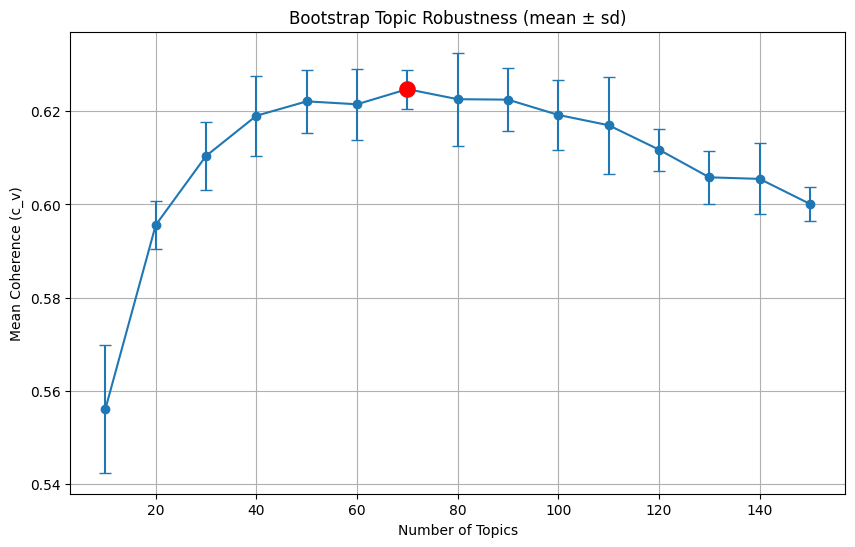

In [19]:
# ============================================================================
# FINAL BLOCK 3: BOOTSTRAP TOPIC STABILITY
# ============================================================================
print("="*80)
print("BLOCK 3: BOOTSTRAP ESTIMATION OF TOPIC QUALITY (B=15)")
print("="*80)

B = 10  # number of bootstrap iterations
topic_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

# Resume previous state if exists
existing_state = load_state()
bootstrap_results = {}

if existing_state and 'bootstrap_results' in existing_state:
    bootstrap_results = existing_state['bootstrap_results']
    print(f"✓ Restarting from saved state — completed: {len(bootstrap_results)} topics")
else:
    print("Starting bootstrap evaluation from scratch...")

# ---- Path to CSV for saving progress ----
progress_csv = "bootstrap_progress.csv"

# If CSV exists, load it (useful if script is restarted)
try:
    df_progress = pd.read_csv(progress_csv)
except FileNotFoundError:
    df_progress = pd.DataFrame(columns=['num_topics','bootstrap_iter','coherence_score'])

# Loop through topic counts
for k in topic_list:

    if k in bootstrap_results:
        print(f"Skipping {k} topics (already completed)")
        continue

    print(f"\n=== Testing {k} topics ===")
    scores_k = []

    for b in range(B):
        print(f" Bootstrap iteration {b+1}/{B}...")

        # ---- BOOTSTRAP SAMPLE ----
        indices = np.random.choice(len(corpus), size=len(corpus), replace=True)
        corpus_b = [corpus[i] for i in indices]
        texts_b = [texts[i] for i in indices]

        # ---- Train model ----
        lda = LdaModel(
            corpus=corpus_b,
            id2word=dictionary,
            num_topics=k,
            passes=10,
            random_state=42 + b,
            chunksize=2000
        )

        # ---- Compute coherence ----
        cm = CoherenceModel(
            model=lda,
            texts=texts_b,
            dictionary=dictionary,
            coherence='c_v'
        )
        score = cm.get_coherence()
        scores_k.append(score)
        print(f"    Score: {score:.4f}")

        # ---- Save intermediate state in memory ----
        bootstrap_results[k] = scores_k
        save_state({
            'dictionary': dictionary,
            'corpus': corpus,
            'texts': texts,
            'bootstrap_results': bootstrap_results
        })

        # ---- Save progress to CSV ----
        df_progress = pd.concat([
            df_progress,
            pd.DataFrame({
                'num_topics': [k],
                'bootstrap_iter': [b+1],
                'coherence_score': [score]
            })
        ], ignore_index=True)

        df_progress.to_csv(progress_csv, index=False)

    print(f"✓ Completed topic={k}: mean={np.mean(scores_k):.4f}  sd={np.std(scores_k):.4f}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("RESULTS — BOOTSTRAP MEAN COHERENCE ± VARIANCE")
print("="*80)

means = []
stds = []

for k in topic_list:
    scores = bootstrap_results[k]
    mean_value = np.mean(scores)
    std_value = np.std(scores)
    means.append(mean_value)
    stds.append(std_value)
    print(f"{k} topics → mean={mean_value:.4f}  sd={std_value:.4f}")

# ---- Best number of topics (highest mean) ----
best_k = topic_list[np.argmax(means)]
print("\n>>> Best number of topics =", best_k)
print("    (using bootstrap mean coherence)")

# ---- Plot ----
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.errorbar(topic_list, means, yerr=stds, fmt='-o', capsize=4)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence (c_v)")
plt.title("Bootstrap Topic Robustness (mean ± sd)")
plt.grid(True)

best_idx = np.argmax(means)
plt.scatter(topic_list[best_idx], means[best_idx], s=120, color='red', zorder=10)
plt.show()


#### 4.b LDA using best_k

We first aligne the DataFrame with the corpus to ensure that each row corresponds to a document used in the LDA model. In fact, there's a slight mismatch between the DataFrame and the corpus occurred because df_filtered was computed twice, and the previously saved corpus (from the first version of df_filtered) was inadvertently used to compute best_k. This is not a major concern, as the small difference in documents does not substantially affect the optimal number of topics, and the coherence scores are generally robust to minor variations in corpus size.

In [21]:
# ============================================================================
# BLOCK 4: FINAL LDA MODEL AND DOCUMENT–TOPIC ASSOCIATION
# ============================================================================
print("="*80)
print("BLOCK 4: FINAL LDA MODEL AND DOCUMENT–TOPIC ASSOCIATION")
print("="*80)

# Train final LDA on best_k topics
lda_final = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_k,
    passes=10,
    random_state=42,
    chunksize=2000
)

# Function to get dense topic distribution
def get_dense_topic_distribution(model, bow, num_topics):
    dist = model.get_document_topics(bow, minimum_probability=0)
    # Convert to dense list
    return [prob for _, prob in sorted(dist, key=lambda x: x[0])]

# Compute topic distributions for each document
topic_distributions = [get_dense_topic_distribution(lda_final, bow, best_k) for bow in corpus]

# Add topic distributions to df_filtered
df_filtered["topics_proportions"] = topic_distributions

# Add columns for first 2 and first 4 topics
for k in range(best_k):
    df_filtered[f"topic_{k}_prop"] = [dist[k] for dist in topic_distributions]

# Optional: create columns for top 2 and top 4 topics per document
df_filtered["top_2_topics"] = df_filtered["topics_proportions"].apply(
    lambda dist: sorted(range(len(dist)), key=lambda i: dist[i], reverse=True)[:2]
)
df_filtered["top_4_topics"] = df_filtered["topics_proportions"].apply(
    lambda dist: sorted(range(len(dist)), key=lambda i: dist[i], reverse=True)[:4]
)

# Save final results to CSV
df_filtered.to_csv("CAIRN_LDA_FINAL.csv", index=False)

print("✓ Final results saved to CAIRN_LDA_FINAL.csv")
print("="*80)
print("BLOCK 4 COMPLETED: LDA model applied and topics associated")
print("="*80)


BLOCK 4: FINAL LDA MODEL AND DOCUMENT–TOPIC ASSOCIATION
✓ Final results saved to CAIRN_LDA_FINAL.csv
BLOCK 4 COMPLETED: LDA model applied and topics associated


In [22]:
display(df_filtered)

,url,Unnamed: 0,titre,auteur,section,twitter_card,journal,annee,numero,page_debut,...,topic_62_prop,topic_63_prop,topic_64_prop,topic_65_prop,topic_66_prop,topic_67_prop,topic_68_prop,topic_69_prop,top_2_topics,top_4_topics
0,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,0.000022,0.006958,0.000022,0.000022,0.000022,0.009589,0.002459,0.000022,"[42, 29]","[42, 29, 48, 55]"
1,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,0.000031,0.000031,0.000031,0.014798,0.000031,0.000031,0.009299,0.000031,"[42, 29]","[42, 29, 48, 44]"
2,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,0.000023,0.000023,0.000023,0.000023,0.000023,0.012548,0.000023,0.000023,"[44, 29]","[44, 29, 8, 42]"
3,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,0.000021,0.002482,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021,"[44, 8]","[44, 8, 48, 29]"
4,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,0.000039,0.000039,0.000039,0.005946,0.000039,0.027251,0.000039,0.000039,"[48, 44]","[48, 44, 29, 9]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89500,https://stm.cairn.info/violences-de-la-maladie...,26782 | 20315 | 22977,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,...,0.000024,0.000024,0.000024,0.000024,0.000024,0.003114,0.023525,0.007844,"[49, 15]","[49, 15, 29, 22]"
89501,https://stm.cairn.info/violences-de-la-maladie...,26782 | 20315 | 22977,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,...,0.000025,0.000025,0.000025,0.000025,0.010709,0.015019,0.000025,0.000025,"[49, 15]","[49, 15, 29, 22]"
89502,https://stm.cairn.info/violences-de-la-maladie...,26782 | 20315 | 22977,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,...,0.000026,0.000026,0.000026,0.000026,0.008558,0.000026,0.041632,0.000026,"[49, 15]","[49, 15, 22, 29]"
89503,https://stm.cairn.info/violences-de-la-maladie...,26782 | 20315 | 22977,2. Géométrie de la souffrance,Claire Marin,Sociologie,summary,Le temps des idées,2015.0,NaN,43,...,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,"[15, 49]","[15, 49, 22, 29]"


In [23]:
# ============================================================================
# DISPLAY ALL TOPICS (TOP WORDS FOR EACH TOPIC)
# ============================================================================

print("\n" + "="*80)
print(f"DISPLAYING ALL {best_k} TOPICS FROM FINAL LDA MODEL")
print("="*80)

# Show each topic with its top 15 words
for topic_id in range(best_k):
    print(f"\n--- Topic {topic_id} ---")
    topic_terms = lda_final.show_topic(topic_id, topn=15)
    for word, weight in topic_terms:
        print(f"{word:20s}  {weight:.4f}")


DISPLAYING ALL 70 TOPICS FROM FINAL LDA MODEL

--- Topic 0 ---
siècle                0.0687
grec                  0.0152
xix                   0.0148
ancien                0.0113
époque                0.0113
latin                 0.0108
romain                0.0096
âge                   0.0096
fin                   0.0092
xviii                 0.0081
histoire              0.0080
moyen                 0.0070
moderne               0.0069
rome                  0.0069
tradition             0.0065

--- Topic 1 ---
jeune                 0.0149
rue                   0.0123
petit                 0.0108
femme                 0.0072
maison                0.0072
pari                  0.0057
passer                0.0052
heure                 0.0051
ami                   0.0051
jour                  0.0051
fille                 0.0045
salle                 0.0045
soir                  0.0045
chambre               0.0045
ville                 0.0044

--- Topic 2 ---
africain              0.0255
afr

In [24]:
# ============================================================================
# BLOCK 5: CONCATENATION AND ENRICHMENT (3 DECIMALS — FINAL VERSION)
# ============================================================================
print("=" * 80)
print("BLOCK 5: CONCATENATION AND ENRICHMENT")
print("=" * 80)

# ---------------------------------------------------------------------------
# Ensure topics_proportions is a real list (if stored as string)
# ---------------------------------------------------------------------------
def to_list(dist):
    if isinstance(dist, str):
        return ast.literal_eval(dist)  # convert string "[0.1,0.2,...]" -> list
    return dist

df_filtered["topics_proportions"] = df_filtered["topics_proportions"].apply(to_list)

# ---------------------------------------------------------------------------
# Ensure top_2_topics and top_4_topics are lists of integers
# ---------------------------------------------------------------------------
def to_int_list(lst):
    if isinstance(lst, str):
        return [int(x) for x in ast.literal_eval(lst)]
    return lst

df_filtered["top_2_topics"] = df_filtered["top_2_topics"].apply(to_int_list)
df_filtered["top_4_topics"] = df_filtered["top_4_topics"].apply(to_int_list)

# ---------------------------------------------------------------------------
# Concatenate all topic proportions into one column (3 decimals)
# ---------------------------------------------------------------------------
def concat_topic_proportions(dist):
    return " | ".join(f"topic_{i}:{prop:.3f}" for i, prop in enumerate(dist))

df_filtered["topics_proportions_concat"] = df_filtered["topics_proportions"].apply(concat_topic_proportions)

# ---------------------------------------------------------------------------
# Add proportions to top 2 and top 4 topics (3 decimals)
# ---------------------------------------------------------------------------
def add_topic_proportions(dist, topics):
    return [(topic, round(dist[topic], 3)) for topic in topics]

df_filtered["top_2_topics_with_prop"] = df_filtered.apply(
    lambda row: add_topic_proportions(row["topics_proportions"], row["top_2_topics"]),
    axis=1
)

df_filtered["top_4_topics_with_prop"] = df_filtered.apply(
    lambda row: add_topic_proportions(row["topics_proportions"], row["top_4_topics"]),
    axis=1
)

# ---------------------------------------------------------------------------
# Drop only individual topic proportion columns (topic_0_prop, topic_1_prop, etc.)
# ---------------------------------------------------------------------------
cols_to_drop = ["topics_proportions", "top_2_topics", "top_4_topics"]
cols_to_drop += [col for col in df_filtered.columns if col.startswith("topic_") and col.endswith("_prop")]

df_filtered.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("✓ Topics concatenated and cleaned (all floats formatted to 3 decimals, only individual topic props dropped)")



BLOCK 5: CONCATENATION AND ENRICHMENT
✓ Topics concatenated and cleaned (all floats formatted to 3 decimals, only individual topic props dropped)


In [25]:
display(df_filtered.head())

,url,Unnamed: 0,titre,auteur,section,twitter_card,journal,annee,numero,page_debut,...,any_author_in_chunk,author_present_in_article_x,author_present_in_article_y,author_present_in_article,chunk_clean,langue,tokens,topics_proportions_concat,top_2_topics_with_prop,top_4_topics_with_prop
0,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,False,True,True,True,l objectif de ce chapitre est d envisager à qu...,fr,"[objectif, chapitre, envisager, forme, rationa...",topic_0:0.000 | topic_1:0.011 | topic_2:0.000 ...,"[(42, 0.328), (29, 0.201)]","[(42, 0.328), (29, 0.201), (48, 0.192), (55, 0..."
1,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,False,True,True,True,elle dépend d autre part de l identité de j do...,fr,"[dépendre, part, identité, donner, identité, d...",topic_0:0.000 | topic_1:0.000 | topic_2:0.000 ...,"[(42, 0.232), (29, 0.128)]","[(42, 0.232), (29, 0.128), (48, 0.122), (44, 0..."
2,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,True,True,True,True,la politique inverse est alors envisageable à ...,fr,"[politique, inverse, envisageable, savoir, imp...",topic_0:0.000 | topic_1:0.000 | topic_2:0.000 ...,"[(44, 0.153), (29, 0.153)]","[(44, 0.153), (29, 0.153), (8, 0.125), (42, 0...."
3,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,False,True,True,True,ils sont supposés maximiser leur utilité de ma...,fr,"[supposer, maximiser, utilité, manière, intert...",topic_0:0.000 | topic_1:0.007 | topic_2:0.000 ...,"[(44, 0.327), (8, 0.157)]","[(44, 0.327), (8, 0.157), (48, 0.149), (29, 0...."
4,https://droit.cairn.info/Economie-des-donnees-...,86147,IV. Les comportements en matière de vie privée...,Fabrice Rochelandet,Sociologie,summary,Repères,2010.0,NaN,67,...,False,True,True,True,un décalage entre les actions présentes et leu...,fr,"[décalage, entrer, action, présenter, futur, c...",topic_0:0.000 | topic_1:0.000 | topic_2:0.000 ...,"[(48, 0.217), (44, 0.193)]","[(48, 0.217), (44, 0.193), (29, 0.173), (9, 0...."


In [26]:

# ============================================================================
# FINAL EXPORT
# ============================================================================
df_filtered.to_csv("CAIRN_LDA_FINAL2.csv", index=False)